In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.mar_model import MAR
%matplotlib inline

In [2]:
# Model Setup
order = 4
nstates = 2

switch_ar = False
switch_sd = False
switch_mean = True

In [4]:
# Load the dataset from Kim and Nelson's website
import requests
f = requests.get('http://econ.korea.ac.kr/~cjkim/MARKOV/data/gdp4795.prn')

# Hamilton's 1989 GNP dataset: Quarterly, 1947.1 - 1995.3
data = pd.DataFrame(
    [float(line) for line in f.content.split('\n')[:-3]],
    index=pd.date_range('1947-01-01', '1995-07-01', freq='QS'),
    columns=['gnp']
)
data['dlgnp'] = np.log(data['gnp']).diff()*100
data = data['1952-01-01':'1984-10-01']

# NBER recessions
from pandas.io.data import DataReader
from datetime import datetime
usrec = DataReader('USREC', 'fred', start=datetime(1952, 1, 1), end=datetime(1984, 12, 1))

In [5]:
mod = MAR(data.dlgnp, 4, nstates)
params = np.array([
    1.15590, -2.20657,
    0.08983, -0.01861, -0.17434, -0.08392,
    -np.log(0.79619),
    -0.21320, 1.12828
])

In [6]:
mod = sm.tsa.MAR(data.dlgnp, order, nstates)

# Set the initial probability values
# see the file's docstring for more information
# In this case, we have the following transition matrix:
# | p_11 p_21 |
# | p_12 p_22 |
# where p_ij is the probability of transitioning from
# state i to state j
# Then the initial transition probabilities should be
# *the first row* of that matrix, i.e. it should be
# | p_11 p_21 |
init_trans_prob = np.r_[0.75, 0.1]
# so I am saying that p_11 = 0.75 and p_22 = 0.9
# i.e. there is a 75% probability of staying in state 1
# if you are already there and a 90% probability of staying
# in state 2 if you are already there.

# Set the full initial parameters array
initial_params = np.array(np.r_[
   np.log(init_trans_prob / (1 - init_trans_prob)),  # transition probabilities (transformed)
   0, 0, 0, 0, # AR parameters
   -np.log(0.8),   # standard deviation (transformed)
   -0.2, 1.0   # Means
])

# Estimate the parameters via MLE
res = mod.fit(initial_params, method='bfgs');
params = res.params

# Transform the unconstrained parameters to interpretable parameters
final_params = params.copy()
final_params[0:2] = np.exp(final_params[0:2]) / (1 + np.exp(final_params[0:2])) # transition probabilities
final_params[6] = np.exp(-final_params[6]) # Standard deviation

Optimization terminated successfully.
         Current function value: 1.369089
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25


In [7]:
# Filter the data
(
    marginal_densities, filtered_joint_probabilities,
    filtered_joint_probabilities_t1
) = mod.filter(params);

transitions = mod.separate_params(params)[0]

# Smooth the data
filtered_marginal_probabilities = mod.marginalize_probabilities(filtered_joint_probabilities[1:])
smoothed_marginal_probabilities = mod.smooth(filtered_joint_probabilities, filtered_joint_probabilities_t1, transitions)

# Save the data
data['filtered'] = np.r_[
    [np.NaN]*order,
    filtered_marginal_probabilities[:,0]
]
data['smoothed'] = np.r_[
    [np.NaN]*order,
    smoothed_marginal_probabilities[:,0]
]

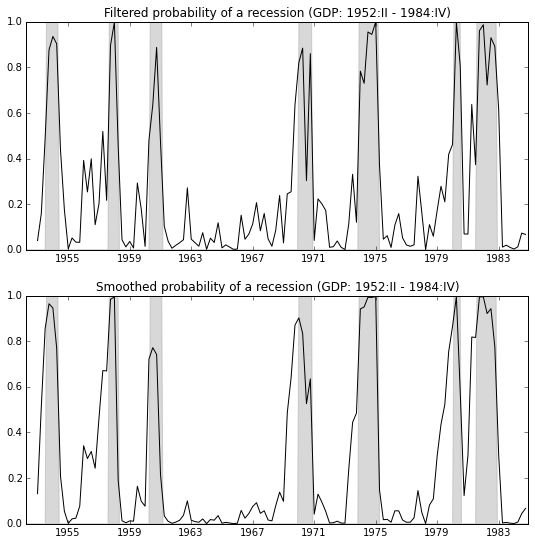

In [10]:
import matplotlib.pyplot as plt
from matplotlib import dates
fig = plt.figure(figsize=(9,9))

ax = fig.add_subplot(211)
ax.fill_between(usrec.index, 0, usrec.USREC, color='gray', alpha=0.3)
ax.plot(data.index, data.filtered, 'k')
ax.set(
    xlim=('1952-04-01', '1984-12-01'),
    ylim=(0,1),
    title='Filtered probability of a recession (GDP: 1952:II - 1984:IV)'
);

ax = fig.add_subplot(212)
ax.fill_between(usrec.index, 0, usrec.USREC, color='gray', alpha=0.3)
ax.plot(data.index, data.smoothed, 'k')
ax.set(
    xlim=('1952-04-01', '1984-12-01'),
    ylim=(0,1),
    title='Smoothed probability of a recession (GDP: 1952:II - 1984:IV)'
);